In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
import sklearn
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers
from keras.callbacks import History
from keras.callbacks import TensorBoard
from IPython.display import Image, SVG
print (tensorflow.__version__)

# Set training parameters
nepochs = 20
batchsize = 128
encoding_dim = 32
# encoding_dim = 16

2025-06-01 00:01:27.862525: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-01 00:01:27.919162: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.18.0


In [2]:
# Prepare our input data using MNIST digits discarding the labels (since we're only interested in encoding/decoding the input images)
# Loads the training and test data sets (ignoring class labels)
(X_train, _), (X_test, _) = mnist.load_data()
X_valid, X_train = X_train[:10000], X_train[10000:]

# Scales the training and test data to range between 0 and 1.
# max_value = float( X_train.max() )
max_value = 255
X_train = X_train.astype('float32') / max_value
X_valid = X_valid.astype('float32') / max_value
X_test = X_test.astype('float32') / max_value

# Data set consists 3D arrays with 60K training and 10K test images.
# with a resolution of 28 x 28 (pixels).
print ( X_train.shape, X_valid.shape, X_test.shape )
# (50000, 28, 28) (10000, 28, 28) (10000, 28, 28)

# Reshape the 28 x 28 images into vectors of length 784
X_train = X_train.reshape( ( len(X_train), np.prod( X_train.shape[1:] ) ) )
X_valid = X_valid.reshape( ( len(X_valid), np.prod( X_valid.shape[1:] ) ) )
X_test = X_test.reshape( ( len(X_test), np.prod( X_test.shape[1:] ) ) )
print ( X_train.shape, X_valid.shape, X_test.shape )
# (50000, 784) (10000, 784) (10000, 784)

# input dimension = 784
input_dim = X_train.shape[1]
print ( "Enonding dimensional: {}, compression: {}".format( encoding_dim, ( encoding_dim/input_dim ) ) )

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(50000, 28, 28) (10000, 28, 28) (10000, 28, 28)
(50000, 784) (10000, 784) (10000, 784)
Enonding dimensional: 32, compression: 0.04081632653061224


In [3]:
# Auto-Encoder Model

# input placeholder
input_img = Input(shape=(784,))

autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Dense(4 * encoding_dim, input_shape=(input_dim,), activation='relu'))
autoencoder.add(Dense(2 * encoding_dim, activation='relu'))
autoencoder.add(Dense(encoding_dim, activation='relu'))

# Decoder Layers
autoencoder.add(Dense(2 * encoding_dim, activation='relu'))
autoencoder.add(Dense(4 * encoding_dim, activation='relu'))
autoencoder.add(Dense(input_dim, activation='sigmoid'))
autoencoder.summary()

####################################################

# ENCODER MODEL
input_img = Input(shape=(input_dim,))
encoder_layer1 = autoencoder.layers[0]
encoder_layer2 = autoencoder.layers[1]
encoder_layer3 = autoencoder.layers[2]
encoder = Model(input_img, encoder_layer3(encoder_layer2(encoder_layer1(input_img))))
encoder.summary()

# DECODER MODEL
encoded_img = Input(shape=(encoding_dim,))
decoder_layer1 = autoencoder.layers[3]
decoder_layer2 = autoencoder.layers[4]
decoder_layer3 = autoencoder.layers[5]
decoder = Model(encoded_img, decoder_layer3(decoder_layer2(decoder_layer1(encoded_img))))
decoder.summary()

/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,384 (868.69 KB)

 Trainable params: 222,384 (868.69 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,816 (432.88 KB)

 Trainable params: 110,816 (432.88 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,568 (435.81 KB)

 Trainable params: 111,568 (435.81 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# TRAINING

# Configure model to use a per-pixel binary crossentropy loss, and the Adam optimizer
autoencoder.compile( optimizer='adam',
                     loss='binary_crossentropy' )

#  train our autoencoder
auto = autoencoder.fit( X_train, X_train,
                        epochs=nepochs,
                        batch_size=batchsize,
                        shuffle=True,
                        validation_data=(X_valid, X_valid) )

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.2987 - val_loss: 0.1526
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1448 - val_loss: 0.1268
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1249 - val_loss: 0.1173
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1164 - val_loss: 0.1114
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1106 - val_loss: 0.1070
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1067 - val_loss: 0.1043
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1040 - val_loss: 0.1018
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1019 - val_loss: 0.1002
Epoch 9/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1005 - val_loss: 0.0991
Epoch 10/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0992 - val_loss: 0.0982
Epoch 11/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0978 - val_loss: 0.0967
Epoch 12/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

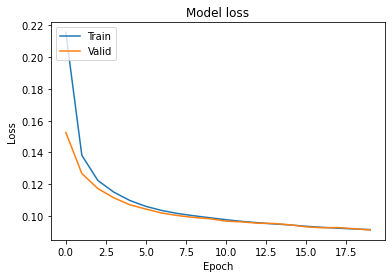

In [5]:
# Plot training & validation loss values
plt.plot(auto.history['loss'])
plt.plot(auto.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


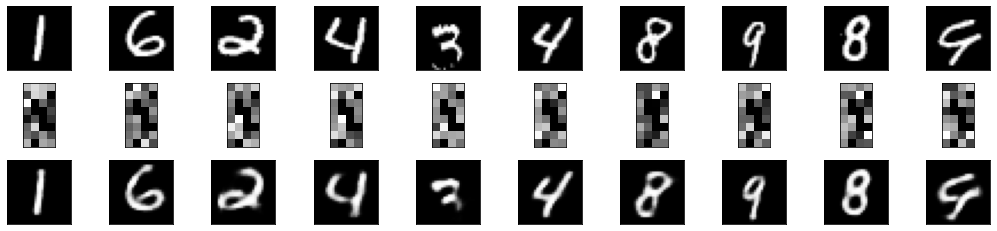

In [6]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint( X_test.shape[0], size=num_images )

encoded_imgs = encoder.predict( X_test )
decoded_imgs = decoder.predict( encoded_imgs )
#decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow( X_test[image_idx].reshape(28, 28) )
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow( encoded_imgs[image_idx].reshape( encoding_dim//4, 4 ) )
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow( decoded_imgs[image_idx].reshape(28, 28) )
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [7]:
from sklearn.cluster import KMeans

k_means = KMeans( n_clusters=10 )
k_means.fit( encoded_imgs )
print ( k_means.labels_ )
print ( k_means.cluster_centers_ )

[9 1 7 ... 9 2 3]
[[9.53551292e+00 8.32469463e+00 7.36122513e+00 1.26983299e+01
  8.58688068e+00 5.80207825e+00 1.05849934e+01 1.97976187e-05
  8.99285316e+00 0.00000000e+00 7.33109426e+00 4.47769117e+00
  6.34476757e+00 0.00000000e+00 0.00000000e+00 6.60085487e+00
  7.22265959e+00 8.82645798e+00 0.00000000e+00 8.59144211e+00
  7.56924820e+00 1.07262983e+01 0.00000000e+00 0.00000000e+00
  1.05231361e+01 5.74378967e+00 4.95632315e+00 1.05730038e+01
  6.06334877e+00 0.00000000e+00 7.78758430e+00 6.03042650e+00]
 [1.34292583e+01 1.10755587e+01 8.76540089e+00 1.06212654e+01
  6.17275953e+00 7.45986605e+00 1.14609385e+01 7.73070497e-12
  1.40106449e+01 0.00000000e+00 9.37347412e+00 3.72649646e+00
  7.27196884e+00 0.00000000e+00 0.00000000e+00 7.55219603e+00
  9.57062626e+00 1.43414326e+01 0.00000000e+00 1.26990404e+01
  1.37141867e+01 1.11409721e+01 0.00000000e+00 0.00000000e+00
  1.00236826e+01 7.00441933e+00 4.95187378e+00 1.22636290e+01
  9.91080475e+00 0.00000000e+00 7.40133619e+00 8.60

In [8]:
df = pd.DataFrame( encoded_imgs )

clusters = k_means.predict( encoded_imgs )
print ( clusters )

df['cluster'] = clusters

[9 1 7 ... 9 2 3]


In [9]:
df

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,cluster
0,9.969427,5.792396,11.481712,13.569972,11.123828,5.253586,15.040541,0.0,16.554356,0.0,...,0.0,19.931469,6.360930,6.159227,9.436097,8.154108,0.0,7.904483,6.373049,9
1,16.284002,17.492542,9.810463,8.449485,5.567443,12.011103,13.117047,0.0,10.398642,0.0,...,0.0,4.611200,14.081487,7.320183,10.919941,8.279839,0.0,12.741364,9.886225,1
2,15.761954,11.118383,11.675251,12.066081,8.029078,9.792482,8.668089,0.0,14.757575,0.0,...,0.0,4.753662,6.454620,5.034308,10.264411,12.428913,0.0,7.981484,7.516767,7
3,10.432076,16.232605,6.670551,11.793814,12.959048,8.012635,15.700089,0.0,15.571935,0.0,...,0.0,19.092043,12.246726,9.401341,15.525866,12.267561,0.0,16.673124,9.151705,6
4,9.831784,12.300184,11.374063,14.889813,14.785471,3.374170,13.094370,0.0,7.611027,0.0,...,0.0,15.109241,8.558198,4.699194,10.385908,4.819408,0.0,7.360953,5.665353,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,16.091948,18.257469,9.490657,9.861106,13.377329,14.696563,15.094111,0.0,17.574511,0.0,...,0.0,11.827793,16.807371,5.931566,12.750210,10.831140,0.0,5.982622,13.410378,4
9996,12.237213,12.147821,7.816499,8.783010,2.003743,6.100165,11.249985,0.0,13.566043,0.0,...,0.0,11.411454,6.332009,11.187439,10.495105,12.358573,0.0,7.918368,6.399992,1
9997,13.881182,12.218045,6.204948,20.291639,14.932704,9.564076,13.784980,0.0,21.940317,0.0,...,0.0,17.206440,6.087147,5.427231,17.381290,6.991050,0.0,8.556287,9.180607,9
9998,10.317146,11.519142,11.382537,12.138142,5.924998,7.461651,18.100548,0.0,8.624009,0.0,...,0.0,17.449293,6.119495,10.871011,12.198833,5.589014,0.0,15.165890,11.223592,2


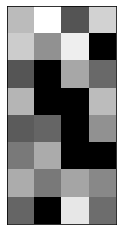

In [10]:
idx = 100
img_ = df.drop(['cluster'],axis=1).iloc[idx].to_numpy()
plt.imshow( img_.reshape( encoding_dim//4, 4 ) )
plt.gray()
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [11]:
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2)
PCs_2d = pd.DataFrame( pca_2d.fit_transform( encoded_imgs ) )
PCs_2d.columns = ["PC1_2d", "PC2_2d"]
PCs_2d['cluster'] = clusters
PCs_2d

,PC1_2d,PC2_2d,cluster
0,-0.340637,-3.454291,9
1,-4.001518,3.830746,1
2,-18.025383,-3.113364,7
3,14.323483,3.205439,6
4,-2.021057,-2.557899,8
...,...,...,...
9995,14.325348,0.863450,4
9996,3.306988,4.386890,1
9997,5.370827,-2.932734,9
9998,-1.173363,-0.727174,2


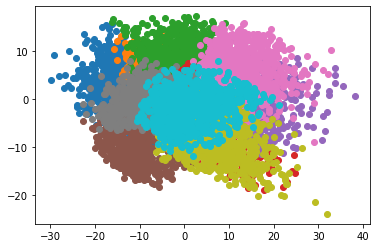

In [12]:
for icluster in range(10):
    msk_ = PCs_2d.cluster == icluster
    plt.plot( PCs_2d[ 'PC1_2d' ][ msk_ ], PCs_2d[ 'PC2_2d' ][ msk_ ], 'o' )

In [14]:
pca_3d = PCA(n_components=3)
PCs_3d = pd.DataFrame( pca_3d.fit_transform( encoded_imgs ) )
PCs_3d.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]
PCs_3d['cluster'] = clusters
PCs_3d

,PC1_3d,PC2_3d,PC3_3d,cluster
0,-0.340637,-3.454291,-2.938981,9
1,-4.001518,3.830746,6.384837,1
2,-18.025383,-3.113364,8.715146,7
3,14.323483,3.205439,-2.062336,6
4,-2.021057,-2.557899,-11.188143,8
...,...,...,...,...
9995,14.325348,0.863450,11.781739,4
9996,3.306988,4.386890,2.198533,1
9997,5.370827,-2.932734,1.106624,9
9998,-1.173363,-0.727174,-2.316831,2


/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


(-0.04, 0.04)

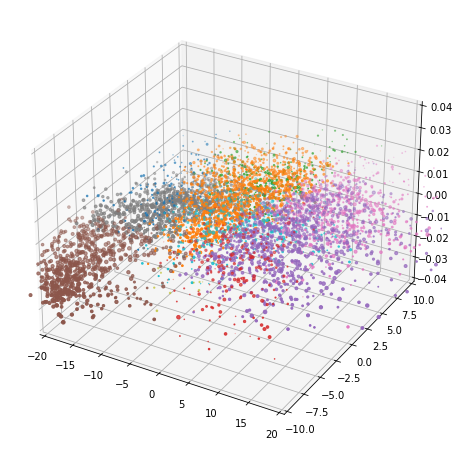

In [15]:
fig = plt.figure( figsize=(10,8) )
ax = fig.add_subplot(projection='3d')

for icluster in range(10):
    msk_ = PCs_3d.cluster == icluster
    plt.scatter( PCs_3d[ 'PC1_3d' ][ msk_ ], PCs_3d[ 'PC2_3d' ][ msk_ ], PCs_3d[ 'PC3_3d' ][ msk_ ], marker='o' )
ax.set_xlim( -20., 20. )
ax.set_ylim( -10., 10. )
ax.set_zlim( -0.04, 0.04 )